# Ejercicio 7 – Predicción con AutoML de H2O.ai

## Parte teórica

### ¿Qué es H2O.ai?

**H2O.ai** es una empresa líder en inteligencia artificial que desarrolla plataformas abiertas para **machine learning automático, ciencia de datos y analítica avanzada**. Su producto estrella es **H2O**, una librería de alto rendimiento para construir modelos predictivos de forma eficiente, escalable y automatizada.

---

#### Productos principales

| Producto           | Descripción breve |
|--------------------|-------------------|
| **H2O-3**           | Plataforma open-source para machine learning con interfaz en R, Python, Java y más. |
| **H2O AutoML**      | Framework que automatiza todo el pipeline de modelado (preprocesamiento, modelos, tuning). |
| **Driverless AI**   | Plataforma comercial avanzada de AutoML con explicabilidad y despliegue incluido. |

---

#### ¿Qué hace especial a H2O?

- Altamente **escalable**: puede ejecutarse en clústeres, Spark o en local.
- **Multilenguaje**: compatible con Python (`h2o`), R, Java y REST.
- Modelos rápidos y optimizados: Random Forest, GBM, XGBoost, Deep Learning, etc.
- **AutoML fácil de usar** y con resultados competitivos.
- Comunidad activa y documentación extensa.

---

#### Casos de uso comunes

- Predicción de demanda o consumo
- Detección de anomalías
- Clasificación y regresión
- Segmentación de clientes
- Modelado predictivo en tiempo real

#### Enlaces H2O AutoML
- [Documentación oficial H2O AutoML (Python)](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
- [Benchmark de modelos de AutoML en H2O](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#model-leaderboard)
- [Qué modelos incluye H2O AutoML](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#automl-models-and-algorithms)
---

### ¿Qué es AutoML?

**AutoML** (Automated Machine Learning) es un enfoque que **automatiza todo el proceso de construcción de modelos de machine learning**, incluyendo:

- Selección del modelo (Random Forest, GBM, XGBoost, Deep Learning, etc.)
- Preprocesamiento de datos
- Ajuste de hiperparámetros
- Validación cruzada
- Selección del mejor modelo

![](https://h2o.ai/content/dam/h2o/images/marketing/blog/2019/lvRcM4RPbCwTbc280SC27A.png)

#### Enlaces AutoML
- [Wikipedia – Automated Machine Learning](https://en.wikipedia.org/wiki/Automated_machine_learning)
- [H2O.ai – What is AutoML](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
- [AutoML vs. Manual ML – H2O.ai Blog](https://h2o.ai/wiki/automated-machine-learning/)
- [Google Cloud – What is AutoML](https://cloud.google.com/automl/docs)

---

### ¿Cómo implementa AutoML H2O.ai?

H2O AutoML pone a disposición de forma automatizada el mejor modelo para un problema de regresión o clasificación. Utiliza una combinación de:

- Modelos base: GLM, GBM, DRF (Random Forest), Deep Learning
- Versiones de XGBoost (si está activado)
- Apilamiento (Stacked Ensembles)
- Grid Search automatizado

Todo esto se controla con unos pocos parámetros: tiempo máximo de entrenamiento, número máximo de modelos, métricas objetivo, etc.

---

### Ventajas de usar AutoML

| Ventajas                                      |
|----------------------------------------------|
| Muy fácil de usar (API clara y rápida)        |
| Modelos competitivos sin esfuerzo manual      |
| Incluye explicaciones e interpretabilidad     |
| Buen rendimiento por defecto                  |
| Soporta regresores multivariables             |

---

### Limitaciones de AutoML

| Limitaciones                                  |
|----------------------------------------------|
| Puede consumir muchos recursos (RAM/CPU)     |
| Poco control sobre decisiones internas       |
| No reemplaza la comprensión del dominio       |
| Más difícil de interpretar que modelos simples|

---

## Ejercicio práctico

---

### Paso 1: Instalación

```bash
pip install h2o
```

### Paso 2: Cargar y preparar datos


In [2]:
import pandas as pd


# Cargar y preparar datos
df = pd.read_csv("data/m5_consumo_energia_train.csv", index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df['dt'] = df.index

# Añadir variables temporales como regresores
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month

# Reset index para pasarlo a H2O
df_h2o = df.reset_index().rename(columns={"dt": "fecha"})


In [3]:
df_h2o.describe()

,index,Energia Consumida,Temperatura,Humedad,fecha,dayofweek,month
count,165,165.000000,165.000000,165.000000,165,165.000000,165.000000
mean,2024-09-21 00:00:00,203.872909,23.119982,72.607667,2024-09-21 00:00:00,2.963636,9.206061
min,2024-07-01 00:00:00,132.550000,18.419000,27.180000,2024-07-01 00:00:00,0.000000,7.000000
25%,2024-08-11 00:00:00,175.540000,22.110000,69.930000,2024-08-11 00:00:00,1.000000,8.000000
50%,2024-09-21 00:00:00,209.160000,23.366000,74.518000,2024-09-21 00:00:00,3.000000,9.000000
75%,2024-11-01 00:00:00,225.550000,23.867000,78.781000,2024-11-01 00:00:00,5.000000,11.000000
max,2024-12-12 00:00:00,300.800000,27.067000,87.700000,2024-12-12 00:00:00,6.000000,12.000000
std,NaN,35.445265,1.442370,9.844408,NaN,2.002714,1.575332


In [10]:
import h2o
from h2o.automl import H2OAutoML

# Iniciar H2O
h2o.init()

# Convertir a H2OFrame
h2o_df = h2o.H2OFrame(df_h2o)

# Definir variables
target = "Energia Consumida"
features = ["Temperatura", "Humedad", "dayofweek", "month"]

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,4 hours 0 mins
H2O_cluster_timezone:,Atlantic/Canary
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,5 months and 1 day
H2O_cluster_name:,H2O_from_python_jballesteros_grqsfa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.575 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


### Paso 3: Dividir en entrenamiento y validación


In [5]:
# Dividir en 80% entrenamiento y 20% test
train, test = h2o_df.split_frame(ratios=[0.8], seed=123)

### Paso 4: Ejecutar AutoML

In [6]:
aml = H2OAutoML(max_runtime_secs=300, seed=1, sort_metric="RMSE")
aml.train(x=features, y=target, training_frame=train)

AutoML progress: |██
19:01:57.21: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 132.0.

█████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),0/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


### Paso 5: Evaluar el modelo

In [7]:
# Ver el leaderboard
lb = aml.leaderboard
lb.head(rows=5)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_1_20250403_190151,23.3856,546.888,19.0594,0.112044,546.888
GBM_grid_1_AutoML_1_20250403_190151_model_2,23.6599,559.789,19.0483,0.113874,559.789
GBM_grid_1_AutoML_1_20250403_190151_model_23,23.9582,573.994,19.4734,0.116229,573.994
GBM_grid_1_AutoML_1_20250403_190151_model_12,23.9947,575.745,19.1483,0.115022,575.745
XGBoost_grid_1_AutoML_1_20250403_190151_model_19,24.0185,576.888,19.5556,0.117375,576.888


### Paso 6: Predicción y visualización

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


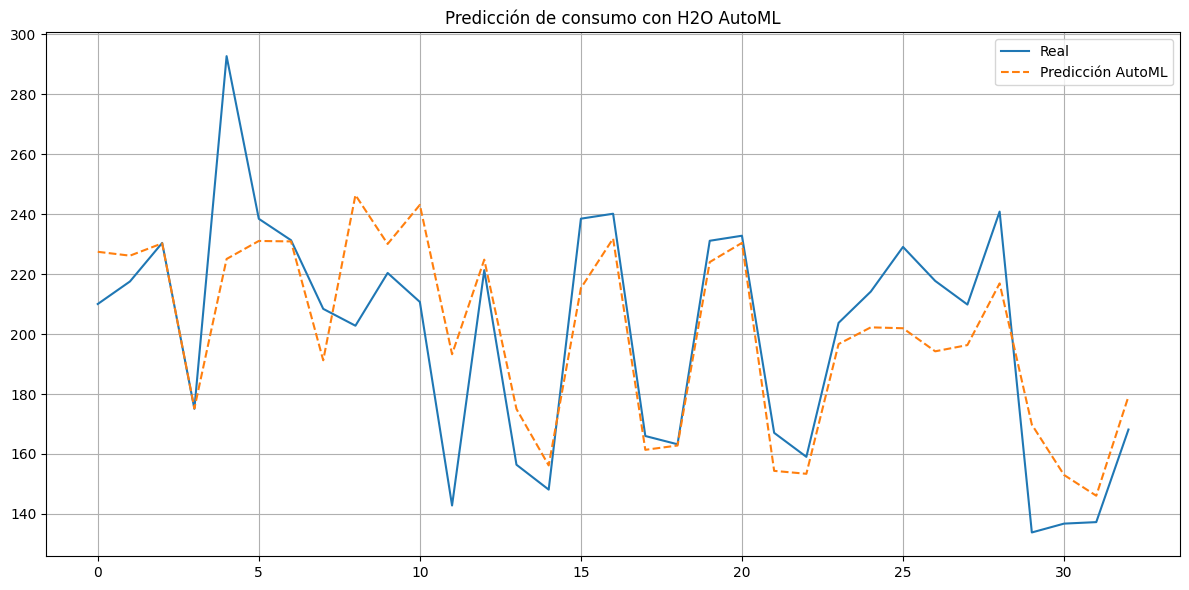

In [8]:
# Predicción sobre conjunto de test
preds = aml.leader.predict(test)

# Convertir a pandas
preds_pd = preds.as_data_frame()
test_pd = test[target].as_data_frame()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_pd.values, label="Real")
plt.plot(preds_pd.values, label="Predicción AutoML", linestyle="--")
plt.title("Predicción de consumo con H2O AutoML")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Paso 7: Interpretación del mejor modelo

In [9]:
# Ver detalles del mejor modelo
aml.leader.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_BestOfFamily_4_AutoML_1_20250403_190151',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_BestOfFamily_4_AutoML_1_20250403_190151'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20250403_190151_training_py_2_sid_a560',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20250403_190151_training_py_2_sid_a560'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20250403_190151_training_py_2_sid_a560',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20250403_190151_training_py_2_sid_a560'}},
 'response_column': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
  

## Recursos adicionales
- [Tutorial oficial: AutoML con H2O](https://www.youtube.com/watch?v=xBfEzm-X-mM)
- [Vídeo tutorial: Quick start with Python](https://www.youtube.com/watch?v=K8J3dPBEz1s)
- [GitHub de H2O.ai (código fuente y notebooks)](https://github.com/h2oai/h2o-3)
- [Notebook oficial de H2O AutoML en Kaggle](https://www.kaggle.com/code/tilii7/h2o-automl-quick-start)
- [Demo de AutoML con datos reales (YouTube)](https://www.youtube.com/watch?v=pzKbjSqtI9Y)


## Conclusiones

- H2O AutoML probará múltiples modelos y combinaciones en menos de 5 minutos.
- Se seleccionará automáticamente el mejor modelo según RMSE.
- Se generará una predicción para el consumo futuro.
- Podrás visualizar resultados y entender qué variables son más relevantes.